# New York 
## Contents
- [Imports](#Data-Dictionary)
- [Regression Modeling](#Regression-Modeling)  
- [Classification Modeling](#Classification-Modeling)  

# Imports

In [26]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, plot_confusion_matrix

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer, QuantileTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [27]:
# Import the data as a dataframe and save to a variable.
df = pd.read_csv('../data/cleaned_engineered_ny.csv')

In [28]:
# Display the first few rows of the dataframe.
df.head(2)

,county_state,total_cases,total_fatalities,death_rate,total_tests,race_pop,race_pop_hispanic_or_latino_of_any_race,race_pop_white_alone,race_pop_black_or_african_american_alone,race_pop_american_indian_and_alaska_native_alone,...,percent_race_pop_other,percent_race_pop_minority,percent_sex_age_pop_0_to_44,percent_sex_age_pop_45_to_74,percent_sex_age_pop_75_and_over,percent_sex_age_pop_0_to_64,percent_sex_age_pop_65_and_over,percent_sex_age_pop_0_to_35,percent_sex_age_pop_35_to_59,percent_sex_age_pop_60_to_84
0,"Albany County, New York",3577.0,128.0,0.035784,176101,307426,17925,223319,35930,322,...,0.033780,0.273585,0.578233,0.351571,0.070196,0.839259,0.160741,0.465114,0.309974,0.200861
1,"Allegany County, New York",271.0,9.0,0.033210,24790,47025,744,44391,639,133,...,0.015481,0.056013,0.558830,0.365019,0.076151,0.820436,0.179564,0.459989,0.294163,0.222243


# Regression Modeling

## Explainable Model: GridSearchCV with Quantile, SelectKBest, Ridge: 81%

In [29]:
# Assign our features to X and y.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_two_or_more_races',
    'percent_race_pop_asian_alone',
    'percent_race_pop_white_alone',    
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'pop_density',
    'tests_per_100_people'
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
# Display the shape of the training and test data.
X_train.shape, X_test.shape

((46, 20), (16, 20))

In [31]:
# Create a pipeline.
pipe = make_pipeline(QuantileTransformer(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,21),
    'ridge__alpha': [.1, 1, 10]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [32]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7ff5ed841b90>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.1, 1, 10],
                         'selectkbest__k': range(1, 21)},
             scoring='r2')

In [33]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 1, 'selectkbest__k': 20}

In [34]:
# Display the score for the test set.
print(f'Test R2 Score: {round(gs.score(X_test, y_test), 4)}.')

Test R2 Score: 0.8128.


In [35]:
# Display the score for the training set.
print(f'Train R2 Score: {round(gs.score(X_train, y_train), 4)}.')

Train R2 Score: 0.7982.


In [36]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print(f'RMSE of Model:{round(mean_squared_error(y_test, y_preds, squared=False), 4)}.')

RMSE of Model:0.4219.


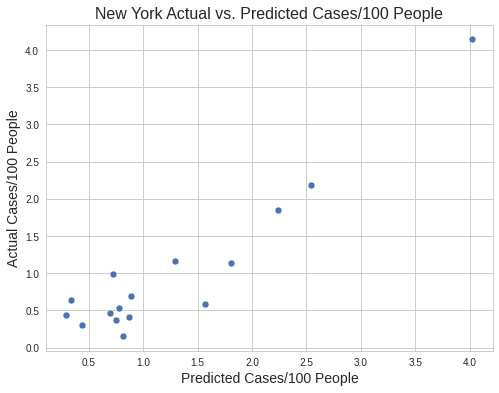

In [37]:
# Plot the predicted versus the actual 'cases_per_100_people'.
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('New York Actual vs. Predicted Cases/100 People', fontsize=16)
plt.xlabel('Predicted Cases/100 People', fontsize=14)
plt.ylabel('Actual Cases/100 People', fontsize=14);

In [38]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()

In [39]:
# Overlay the boolean matrix with the features to get the features used.
features = X_train.columns[features==True]

In [40]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['ridge'].coef_

In [41]:
# Create a dataframe of the features and their coefficients.
coef_df = pd.DataFrame(list(zip(features, coefs)), columns=['Feature', 'Coefficients'])
coef_df = coef_df.set_index('Feature')
coef_df = coef_df.sort_values(by='Coefficients', ascending=False)

In [42]:
# Rename the index.
coef_df = coef_df.rename(index={
    'inc_per_capita_inc_dol': 'Income Per Capita ($)',
    'percent_inc_hhlds_50_000_to_99_999': 'Income: $50-100,000',
    'percent_inc_hhlds_less_than_99_999': 'Income: < $100,000',
    'percent_inc_hhlds_100_000_or_more': 'Income: > $100,000',
    'obes_percent': 'Obesity (%)',
    'pop_density': 'Population Density',
    'percent_health_ins_noninst_pop_cov_no': 'Health Insurance: None (%)',
    'percent_health_ins_noninst_pop_cov_yes': 'Health Insurance: Yes (%)',
    'percent_sex_age_pop_male': 'Sex: Male (%)',
    'percent_sex_age_pop_under_5': 'Age: Under 5 Yrs (%)',
    'percent_sex_age_pop_5_to_9': 'Age: 5-9 Yrs (%)',
    'percent_sex_age_pop_10_to_14': 'Age: 10-14 Yrs (%)',
    'percent_sex_age_pop_15_to_19': 'Age: 15-19 Yrs (%)',
    'percent_sex_age_pop_20_to_24': 'Age: 20-24 Yrs (%)',
    'percent_sex_age_pop_25_to_34': 'Age: 25-34 Yrs (%)',
    'percent_sex_age_pop_35_to_44': 'Age: 35-44 Yrs (%)',
    'percent_sex_age_pop_45_to_74': 'Age: 45-75 Yrs (%)',
    'percent_sex_age_pop_75_and_over': 'Age: 75+ Yrs (%)',
    'percent_sex_age_pop_0_to_44': 'Age: 0-44 Yrs (%)',
    'percent_race_pop_asian_alone': 'Race: Asian (%)',
    'percent_race_pop_american_indian_and_alaska_native_alone': 'Race: American Indian/Alaskan (%)',
    'percent_race_pop_native_hawaiian_and_other_pacific_islander_alone': 'Race: Pacific Islander (%)',
    'percent_race_pop_black_or_african_american_alone': 'Race: Black/African American (%)',
    'percent_race_pop_hispanic_or_latino_of_any_race': 'Race: Hispanic/Latino (%)',
    'percent_race_pop_two_or_more_races': 'Race: Two or More Races (%)',
    'percent_race_pop_some_other_race_alone': 'Race: Other (%)',
    'percent_race_pop_white_alone': 'Race: White (%)',
    'tests_per_100_people': 'Tests/100 People'
})

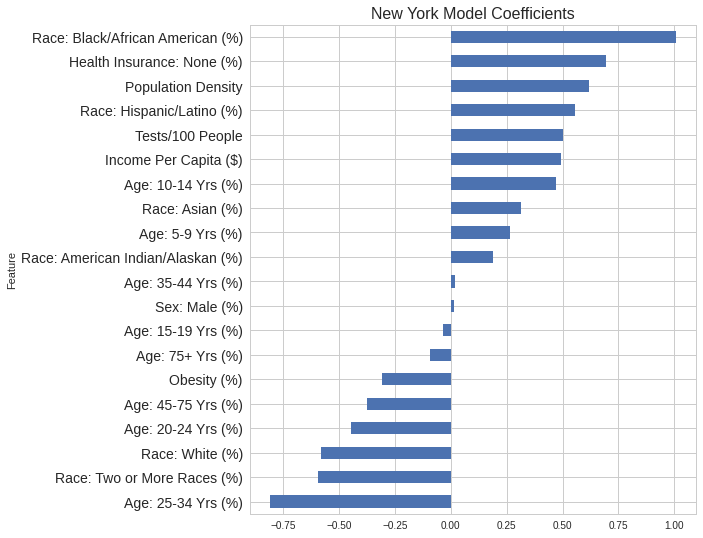

In [43]:
# Plot the datatframe of the features and their coefficients.
coef_df.sort_values(by='Coefficients').plot(kind = 'barh', figsize=(8,9), legend=None)
plt.title('New York Model Coefficients', fontsize=16)
plt.yticks(fontsize=14);

### Create a smaller coefficient dataframe

In [44]:
coef_neg = coef_df.sort_values(by='Coefficients')[:5]

In [45]:
coef_pos = coef_df.sort_values(by='Coefficients', ascending=False)[:5]

In [46]:
coef_df = pd.concat([coef_neg, coef_pos]).sort_values(by='Coefficients', ascending=False)

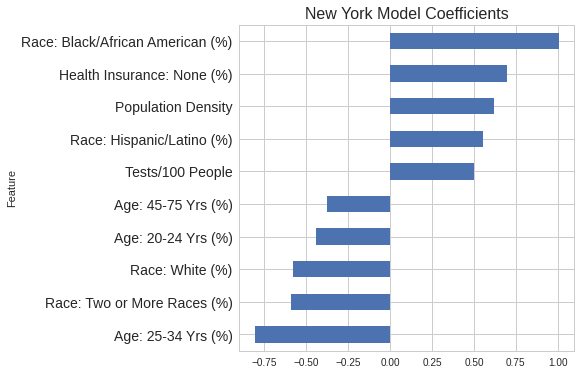

In [48]:
# Plot the datatframe of the features and their coefficients.
coef_df.sort_values(by='Coefficients').plot(kind = 'barh', figsize=(6,6), legend=None)
plt.title('New York Model Coefficients', fontsize=16)
plt.yticks(fontsize=14);

## Blackbox Model: Quantile, Polynomial, Gridsearch, Ridge: 81%

In [19]:
# Assign our features to X and y.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_two_or_more_races',
    'percent_race_pop_asian_alone',
    'percent_race_pop_white_alone',    
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'pop_density',
    'tests_per_100_people',
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
# Display the shape of the training and test data.
X_train.shape, X_test.shape

((46, 20), (16, 20))

In [21]:
# Create a pipeline.
pipe = make_pipeline(QuantileTransformer(), PolynomialFeatures(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'ridge__alpha': [.1, 1, 10]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [22]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f4507332b90>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.1, 1, 10],
                         'selectkbest__k': range(1, 300)},
             scoring='r2')

In [23]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 1, 'selectkbest__k': 112}

In [24]:
# Display the score for the test set.
print(f'Test R2 Score: {round(gs.score(X_test, y_test), 4)}.')

Test R2 Score: 0.8074.


In [25]:
# Display the score for the training set.
print(f'Train R2 Score: {round(gs.score(X_train, y_train), 4)}.')

Train R2 Score: 0.9143.


In [26]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print(f'RMSE of Model:{round(mean_squared_error(y_test, y_preds, squared=False), 4)}.')

RMSE of Model:0.4279.


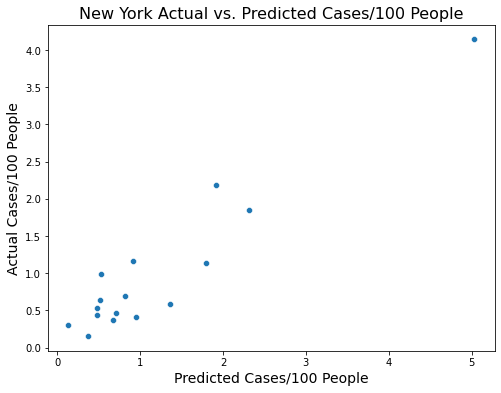

In [27]:
# Plot the predicted versus the actual 'cases_per_100_people'.
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('New York Actual vs. Predicted Cases/100 People', fontsize=16)
plt.xlabel('Predicted Cases/100 People', fontsize=14)
plt.ylabel('Actual Cases/100 People', fontsize=14);

# Classification Modeling

## Simple Model: GridSearchCV with Classifier: 94% (baseline 81)

In [28]:
# Assign our features to X and y.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_two_or_more_races',
    'percent_race_pop_asian_alone',
    'percent_race_pop_white_alone',    
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'pop_density',
    'tests_per_100_people',
]]

y = df['covid_severity']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [29]:
# Display the shape of the training and test data.
X_train.shape, X_test.shape

((46, 20), (16, 20))

In [30]:
# Display the baseline percentages.
y_test.value_counts(normalize=True)

1    0.8125
3    0.1250
2    0.0625
Name: covid_severity, dtype: float64

In [31]:
# Create a pipeline.
pipe = make_pipeline(QuantileTransformer(), SelectKBest(), LogisticRegression())

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,21),
    'logisticregression__C': [.1, .5, 1, 10]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1)

In [32]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1, 10],
                         'selectkbest__k': range(1, 21)})

In [33]:
# Display the best parameters.
gs.best_params_

{'logisticregression__C': 10, 'selectkbest__k': 2}

In [34]:
# Display the score for the test set.
print(f'Test Accuracy: {round(gs.score(X_test, y_test), 4)}.')

Test Accuracy: 0.9375.


In [35]:
# Display the score for the training set.
print(f'Train Accuracy: {round(gs.score(X_train, y_train), 4)}.')

Train Accuracy: 0.9565.


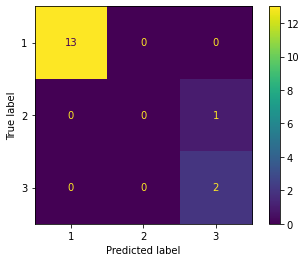

In [36]:
# Plot a confusion matrix.
y_preds = gs.predict(X_test)
plot_confusion_matrix(gs, X_test, y_test);

In [37]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()

In [38]:
# Overlay the boolean matrix with the features to get the features used.
features = X_train.columns[features==True]

In [39]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['logisticregression'].coef_

In [40]:
# Extract coefficients for each class and save to a variable.
coef1 = coefs[0]
coef2 = coefs[1]
coef3 = coefs[2]

In [41]:
pd.DataFrame(list(zip(features, coef1)), columns=['Feature', 'Covid Severity Low'])

,Feature,Covid Severity Low
0,percent_race_pop_hispanic_or_latino_of_any_race,-4.174190
1,percent_race_pop_white_alone,3.752613


In [42]:
pd.DataFrame(list(zip(features, coef2)), columns=['Feature', 'Covid Severity Medium'])

,Feature,Covid Severity Medium
0,percent_race_pop_hispanic_or_latino_of_any_race,1.420183
1,percent_race_pop_white_alone,-1.015642


In [43]:
pd.DataFrame(list(zip(features, coef3)), columns=['Feature', 'Covid Severity High'])

,Feature,Covid Severity High
0,percent_race_pop_hispanic_or_latino_of_any_race,2.754008
1,percent_race_pop_white_alone,-2.736970


## Blackbox Model: Quantile, Polynomial, Gridsearch, Classifier: 81% (baseline 81)

In [44]:
# Assign our features to X and y.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_two_or_more_races',
    'percent_race_pop_asian_alone',
    'percent_race_pop_white_alone',    
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'pop_density',
    'tests_per_100_people',
]]

y = df['covid_severity']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [45]:
# Display the shape of the training and test data.
X_train.shape, X_test.shape

((46, 20), (16, 20))

In [46]:
# Display the baseline percentages.
y_test.value_counts(normalize=True)

1    0.8125
3    0.1250
2    0.0625
Name: covid_severity, dtype: float64

In [47]:
# Create a pipeline.
pipe = make_pipeline(QuantileTransformer(), PolynomialFeatures(), SelectKBest(), LogisticRegression())

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'logisticregression__C': [.1, .5, 1, 10]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1)

In [48]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1, 10],
                         'selectkbest__k': range(1, 300)})

In [49]:
# Display the best parameters.
gs.best_params_

{'logisticregression__C': 0.1, 'selectkbest__k': 81}

In [50]:
# Display the score for the test set.
print(f'Test Accuracy: {round(gs.score(X_test, y_test), 4)}.')

Test Accuracy: 0.875.


In [51]:
# Display the score for the training set.
print(f'Train Accuracy: {round(gs.score(X_train, y_train), 4)}.')

Train Accuracy: 0.9565.


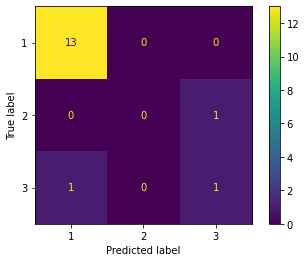

In [52]:
# Plot a confusion matrix.
y_preds = gs.predict(X_test)
plot_confusion_matrix(gs, X_test, y_test);